In [44]:
from easypip import easyimport, easyinstall, is_notebook
easyinstall("bbrl>=0.2.2")
easyinstall("swig")
easyinstall("bbrl_gymnasium>=0.2.0")
easyinstall("bbrl_gymnasium[box2d]")
easyinstall("bbrl_gymnasium[classic_control]")
easyinstall("tensorboard")
easyinstall("moviepy")
easyinstall("box2d-kengz")

[easypip] Installing bbrl_gymnasium>=0.2.0
[easypip] Installing bbrl_gymnasium[box2d]
[easypip] Installing bbrl_gymnasium[classic_control]


In [45]:
import os
import sys
from pathlib import Path
import math
import numpy as np

from moviepy.editor import ipython_display as video_display
import time
from tqdm.auto import tqdm
from typing import Tuple, Optional
from functools import partial

from omegaconf import OmegaConf
import torch
import bbrl_gymnasium

import copy
from abc import abstractmethod, ABC
import torch.nn as nn
import torch.nn.functional as F
from time import strftime

from gymnasium import Env, Space, Wrapper, make

from bbrl.agents.agent import Agent
from bbrl import get_arguments, get_class, instantiate_class
from bbrl.workspace import Workspace
from bbrl.agents import Agents, TemporalAgent
from bbrl.agents.gymnasium import GymAgent, ParallelGymAgent, make_env, record_video
from bbrl.utils.replay_buffer import ReplayBuffer

import torch.nn as nn

from typing import Tuple
from bbrl.agents.gymnasium import make_env, GymAgent, ParallelGymAgent
from functools import partial

from bbrl import instantiate_class

import matplotlib.pyplot as plt

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

from IPython.display import clear_output

import cv2
import numpy as np

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten

import random as python_random
import tensorflow as tf

In [46]:
# Utility function for launching tensorboard
# For Colab - otherwise, it is easier and better to launch tensorboard from
# the terminal
def setup_tensorboard(path):
    path = Path(path)
    answer = ""
    if is_notebook():
        if get_ipython().__class__.__module__ == "google.colab._shell":
            answer = "y"
        while answer not in ["y", "n"]:
                answer = input(f"Do you want to launch tensorboard in this notebook [y/n] ").lower()

    if answer == "y":
        get_ipython().run_line_magic("load_ext", "tensorboard")
        get_ipython().run_line_magic("tensorboard", f"--logdir {path.absolute()}")
    else:
        import sys
        import os
        import os.path as osp
        print(f"Launch tensorboard from the shell:\n{osp.dirname(sys.executable)}/tensorboard --logdir={path.absolute()}")

In [47]:
SEED = 42

params={
  "save_best": False,
  "logger":{
    "classname": "bbrl.utils.logger.TFLogger",
    "log_dir": "./tblogs/dqn-buffer-" + str(time.time()),
    "cache_size": 10000,
    "every_n_seconds": 10,
    "verbose": False,    
    },

  "algorithm":{
    "seed": SEED,
    "max_grad_norm": 0.5,
    "epsilon": 0.02,
    "n_envs": 8,
    "n_steps": 32,
    "n_updates": 32,
    "eval_interval": 2000,
    "learning_starts": 2000,
    "nb_evals": 10,
    "buffer_size": 1e6,
    "batch_size": 256,
    "target_critic_update": 5000,
    "max_epochs": 100, #MAX ITER 
    "discount_factor": 0.99,
    "architecture":{"hidden_size": [64, 64]},
  },
  "gym_env":{
    "env_name": "CartPole-v1",
  },
  "optimizer":
  {
    "classname": "torch.optim.Adam",
    "lr": 1e-3,
  }
}

config=OmegaConf.create(params)

In [48]:
def set_seeds(seed):
    np.random.seed(seed)
    python_random.seed(seed)
    tf.random.set_seed(seed)

class oldCnnAgent:
    def __init__(self):
        set_seeds(SEED) 

    def build_feature_extractor_model(self, input_shape):
        model = Sequential()
        model.add(Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding="same", input_shape=(151, 562, 1)))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Conv2D(64, (7, 7), strides=(2, 2), padding="same", activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Conv2D(64, (7, 7), strides=(2, 2), padding="same", activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2), padding="same"))
        model.add(Flatten())
        model.add(Dense(100, activation='relu')) #a changer la valeur ici pour la taille du ouput
        return model

    def extract_features(self, image):
        image_resized = np.expand_dims(np.expand_dims(image, axis=-1), axis=0)  
        if not hasattr(self, 'model'):
            self.model = self.build_feature_extractor_model(input_shape=image_resized.shape[1:])
        features = self.model.predict(image_resized)
        return features[0]


TEST AVEC UN RANDOM AGENT

In [49]:
class RandomAgent(Agent):
    def __init__(self, action_dim):
        super().__init__()
        self.action_dim = action_dim
        self.all_observations = []

    def forward(self, t: int, choose_action=True, **kwargs):
        """An Agent can use self.workspace"""
        obs = self.get(("env/env_obs", t))
        action = torch.randint(0, self.action_dim, (len(obs), ))
        self.set(("action", t), action)
        self.all_observations.append(obs)


In [50]:
class StateCaptureAgent(Agent):
    def __init__(self, storage_list):
        super().__init__()
        self.storage_list = storage_list  # This list will store the states

    def forward(self, t: int, **kwargs):
        # Retrieve the current state (observation) from the workspace
        current_state = self.get(("env/env_obs", t))
        # Append the current state to the storage list
        self.storage_list.append(current_state)
        

In [51]:
class CustomParallelGymAgent(ParallelGymAgent):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def get_my_attribute(self):
        # Replace 'my_attribute' with the actual attribute you're interested in
        return self.envs

In [58]:
class AttributeAccessAgent(Agent):
    def __init__(self, env_agent, list_images, pre_processing_agent, cnn_agent):
        super().__init__()
        self.env_agent = env_agent  # CustomParallelGymAgent ou ParallelGymAgent
        #init de la liste de listes pour store les images
        self.list_images = [[] for _ in range(self.env_agent.num_envs)]
        self.pre_processing_agent = pre_processing_agent
        self.cnn_agent = cnn_agent
        self.list_features = [[] for _ in range(self.env_agent.num_envs)]
    
    def forward(self, t: int, **kwargs):
        for env_index in range(self.env_agent.num_envs):
            # Assuming your env_agent can provide access to each environment's render method
            image = self.env_agent.envs[env_index].render()
            display = False
            if display: #print a chaque temps l'image originale
                clear_output(wait=True)  # pour print live mais pas utile pour +1 env
                plt.imshow(image)  
                plt.axis('off')
                plt.show()
                print("Displayed image at time", t, " of agent ", env_index)
            #print(image.shape)
            image_pre_processed = self.pre_processing_agent.preprocess(image)

            # Append the image to the corresponding list
            self.list_images[env_index].append(image_pre_processed)

            # attention a bien mettre l'image preprocessed ici sinon y a des pb avec le cnn
            features = self.cnn_agent.process_image(image_pre_processed) 
            #print(features.shape)
            self.list_features[env_index].append(features)

In [53]:
class PreProcessingAgent(Agent):
    def __init__(self):
        super().__init__()

    def preprocess(self, image):
        # Assume image is a numpy array of shape (400, 600, 3)
        # Convert to grayscale, resize, and ensure correct shape for CNN
        processed_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        processed_image = cv2.resize(processed_image, (224, 224))  # Resize to expected CNN input size
        return processed_image #image de taille (224, 224)

In [54]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolution layer 1
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 16 x 112 x 112
            
            # Convolution layer 2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 32 x 56 x 56
            
            # Convolution layer 3
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64 x 28 x 28
            
            # Convolution layer 4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128 x 14 x 14
            
            # Convolution layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 256 x 7 x 7
        )
        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),  # The output feature vector size
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [55]:
class CNNAgent(Agent):
    def __init__(self):
        super().__init__()
        self.cnn = CNN()  

    def process_image(self, image):
        # Convert a single preprocessed image to PyTorch tensor
        image_tensor = torch.tensor(image, dtype=torch.float).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, 224, 224]
        image_tensor = image_tensor / 255.0  

        with torch.no_grad():
            features = self.cnn(image_tensor)
        return features.cpu().numpy()


In [56]:
def displayImagesPerAgent(images_per_agent, nb_env):
    n_cols = 3  # Number of columns in the grid
    
    for env_index, images in enumerate(images_per_agent):
        print(f"Environment {env_index + 1}:")
        n_images = len(images)
        n_rows = (n_images + n_cols - 1) // n_cols  # Rows per environment

        figsize_width = 10  # Adjust width as needed
        figsize_height = n_rows * (figsize_width / n_cols) * 0.5  # Adjust height based on number of rows, keeping aspect ratio
        plt.figure(figsize=(figsize_width, figsize_height))

        for i, image in enumerate(images):
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(image)
            plt.axis('off')  # Optional: to hide axes
        
        plt.tight_layout()
        plt.show()

Donzo got all images
Environment 1:


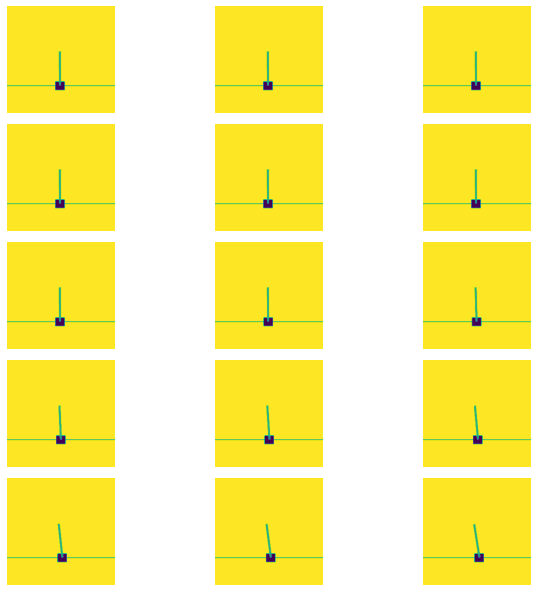

In [60]:
nb_env = 1
action_dim = 2 #vaudrait mieux prednre depuis le parallelgymagent mais ca va jamais changer ici
#autoreset = False pour le moment pouor le simplifier la vie
pre_processing_agent = PreProcessingAgent()
cnn_agent = CNNAgent()

im_env_agent = CustomParallelGymAgent(partial(make_env, config.gym_env.env_name, render_mode="rgb_array", autoreset=False), nb_env).seed(SEED)
attribute_access_agent = AttributeAccessAgent(im_env_agent, [], pre_processing_agent, cnn_agent)
agents = Agents(im_env_agent, RandomAgent(action_dim), attribute_access_agent)
t_agents = TemporalAgent(agents)

workspace = Workspace()
t_agents(workspace, t=0, stop_variable="env/done", stochastic=True)
images = attribute_access_agent.list_images #bon seul soucis c'est qu'on recupere les images apres coup
print('Donzo got all images')
displayImagesPerAgent(images, nb_env)

OK ON VA ESSAYER DE FAIRE UN AGENT DQN MAINTENANT